In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import datasets
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from gensim import corpora, models, matutils
import nltk
pd.set_option('display.max_rows', 2000)


In [2]:
import spacy
nlp = spacy.load('en_core_web_sm')

In [4]:
import re
docs_df = pd.read_pickle('docs_raw.pkl')
docs_df['ep_name']=docs_df.ep_name.apply(lambda x: x.strip('- '))
docs_df['no_char']=docs_df.lines.apply(lambda x: len(x))

In [50]:
dwight_df

,episode_no,ep_name,lines,season,ep,no_char,spacy_doc,clean_doc
157,"(2, 4)",The Fire,michael's in there right now evaluating the t...,2,4,3429,"( , michael, 's, in, there, right, now, evalua...",michael temp year michael connection batman ro...
107,"(2, 6)",The Fight,where is my desk? this is not funny. this is ...,2,6,2683,"( , where, is, my, desk, ?, this, is, not, fun...",desk desk desk michael office bathroom phone d...
173,"(2, 5)",Halloween,[eyeing jim's costume] what is that?! what ar...,2,5,2539,"( , [, eyeing, jim, 's, costume, ], what, is, ...",jim costume hood head saber sith lord jim deal...
190,"(2, 18)",Take Your Daughter to Work Day,[looks at sasha] mmm... hello tiny one. you a...,2,18,1999,"( , [, looks, at, sasha, ], mmm, ..., hello, t...",sasha mmm future way girl hand day abby hand j...
126,"(2, 21)",Conflict Resolution,oh! what is on your face? is that a disguise?...,2,21,1860,"( , oh, !, what, is, on, your, face, ?, is, th...",face disguise clown paint i.d badge security o...
141,"(2, 12)",The Injury,"[silence, dwight enters the office] what is g...",2,12,1762,"( , [, silence, ,, dwight, enters, the, office...",silence dwight office michael michael foot min...
3,"(2, 1)",The Dundies,mine are at home in a display case above my b...,2,1,1685,"( , mine, are, at, home, in, a, display, case,...",home display case bed joke dave barry company ...
47,"(2, 9)",E-Mail Surveillance,"mi- sorry. ok, i'm sorry. what is going on in...",2,9,1605,"( , mi-, sorry, ., ok, ,, i, 'm, sorry, ., wha...",mi- michael god forbid order brain car- bus tr...
94,"(2, 16)",Valentine's Day,and you want me to come with you. i will stay...,2,16,1312,"( , and, you, want, me, to, come, with, you, ....",thing end question jan new york valentine day ...
29,"(2, 14)",The Carpet,[coughing] it's still stinky. she probably sc...,2,14,844,"( , [, coughing, ], it, 's, still, stinky, ., ...",fiber carpet permeation foot desk bullpen mm w...


In [5]:
dwight_df = docs_df[docs_df.character=='Dwight']
dwight_df.drop(columns=['character'], inplace=True)
dwight_df['spacy_doc']=list(nlp.pipe(dwight_df.lines))

/Users/aathirachennat/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
<ipython-input-5-f59fb0251ed1>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dwight_df['spacy_doc']=list(nlp.pipe(dwight_df.lines))


In [186]:
clean_docs = [[token.lemma_.lower() for token in doc
              if (not token.is_stop and not token.is_punct and not token.like_num )&
              (token.pos_=='NOUN' or token.pos_=='PROPN' or
               token.pos_=="X")] for doc in dwight_df.spacy_doc]
dwight_df['clean_doc']=[' '.join(doc) for doc in clean_docs]
dwight_df['clean_doc']=dwight_df['clean_doc'].apply(lambda x: 
                                                    x.replace('phylli ', 'phyllis ').replace('monkey', 'angela'))

<ipython-input-186-dbe723e29efa>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dwight_df['clean_doc']=[' '.join(doc) for doc in clean_docs]
<ipython-input-186-dbe723e29efa>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dwight_df['clean_doc']=dwight_df['clean_doc'].apply(lambda x:


In [233]:
#determine topics
def get_topics(n_topics, n_terms, model, term_list):
    for i in range(n_topics):
        topic_weights_full = np.argsort(model.components_[i])
        top_terms =  topic_weights_full[
            len(topic_weights_full): (len(topic_weights_full)-(n_terms+1)):-1]
    
    # get term indices, sorted (descending) by topic weights    
        topic_weights = np.array(model.components_[i][top_terms[0]])
        for b in top_terms[1:]:
            topic_weights= np.append(topic_weights, model.components_[i][b])
    # use the `terms` array to get the actual top terms

            term_names = [terms[item] for item in top_terms]
        print(i, topic_weights, term_names)

In [375]:
stopwords = nltk.corpus.stopwords.words('english')
words_to_cut =['look', 'thank', 'come', 'new', 'thing', 'get', 'great', 'good',
               'day', 'let', 'say', 'start', 'leave', 'new', 'little', 'year', 'guy',
              'phone', 'wait', 'sight', 'sign', 'tell', 'work', 'ok', 'room', 'people', 
               'mm', 'hmm', 'hour', 'room', 'hour', 'way', 'fact', 'time', 'hand',
               'thing', 'mr', 'camera', 'god', 'man', 'kind', 'place', 'morning', 'man',
              'night', 'tonight', 'today', 'thought', 'need', 'stuff', 'right', 'month', 
              'person', 'lunch', 'door', 'floor', 'woah', 'whoo', 'yaaaaa', 'yadda', 'mmm', 'ahh',
              'argh', 'cell', 'cent', 'end', 'ear', 'eye', 'ga', 'gahh', 'gah', 'ii', 'hoo', 'nod',
              'exhale', 'bagel', 'aaagh', 'aaaah', 'awhile', 'aha', 'baaah', 'aaah', 'area', 'abou'
              'aah', 'aaaaah', 'minute', 'car', 'life', 'lot', 'line']
stopwords.extend(words_to_cut)

In [343]:
cv = CountVectorizer(lowercase=False, stop_words = stopwords) 
X=cv.fit_transform(dwight_df.clean_doc)
doc_term_df = pd.DataFrame(X.toarray(), columns=cv.get_feature_names())
terms = np.array(doc_term_df.columns.to_list())

In [325]:
doc_term_df.banana.sum()

3

In [341]:
tfidf = TfidfVectorizer(stop_words = stopwords, min_df=0.15,
                       lowercase = False) # keeps words of 3 or more characters
X_idf=tfidf.fit_transform(dwight_df.clean_doc)
doc_term_idf_df = pd.DataFrame(X_idf.toarray(), columns=tfidf.get_feature_names())
terms_idf = np.array(doc_term_idf_df.columns.to_list())

In [344]:
from sklearn.decomposition import NMF
nmf = NMF(10)
nmf.fit(doc_term_idf_df)
get_topics(10, 5, nmf, terms_idf)

0 [2.29734726 0.46435605 0.4385052  0.24878024 0.16115741] ['adam', 'advantage', 'abby', 'abdomen', 'accent']
1 [1.62310677 0.22311181 0.1514973  0.14647804 0.14583489] ['accessory', 'agency', 'acceptance', 'abby', 'afterthought']
2 [1.52420626 0.17602543 0.14571389 0.11603201 0.06502861] ['aaaagh', 'affiliation', 'accent', 'abby', 'accounting']
3 [1.37215509 0.44434922 0.23672818 0.17218956 0.04111363] ['advertising', 'acceptance', 'agency', 'affiliation', 'act']
4 [1.25737795 0.28239105 0.23179299 0.20611646 0.17805001] ['affair', 'address', 'accountant', 'accento', 'accident']
5 [1.14511099 0.35975422 0.12397027 0.11299499 0.10349037] ['access', 'aah', 'advance', 'advice', 'accento']
6 [1.47469552 0.15346656 0.10346289 0.08053825 0.06817587] ['5k', 'accent', 'advantage', 'abby', 'aah']
7 [1.10207439 0.32948536 0.23838214 0.2200872  0.12597728] ['action', 'accident', 'accounting', 'abou', 'adam']
8 [1.055164   0.53893441 0.50997777 0.49149111 0.47328602] ['abou', 'advice', 'age', 'ag

/Users/aathirachennat/opt/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "


In [ ]:
['michael'], 
                           ['angela', 'valentine', 'intercourse', 'sex', 'contract'],
                           ['jim', 'desk', 'paper'], ['manager', 'title', 'position', 'control'],
                           ['safe', 'survival'], ['goat', 'manure', 'mose', 'cousin', 'schrute', 'farm']

In [374]:
from corextopic import corextopic as ct
topic_model = ct.Corex(n_hidden=7, words=[i for i in terms], seed=1)
topic_model.fit(X, words=[i for i in terms], docs=dwight_df.clean_doc,
                anchors = [['michael', 'assistant'], ['manager', 'title', 'position', 'control'],
                           ['goat', 'manure', 'mose', 'cousin', 'schrute', 'farm'], ['jim', 'revenge'],['angela']],
                anchor_strength=10
                )
topics = topic_model.get_topics()
for n,topic in enumerate(topics):
    topic_words,_,_ = zip(*topic)
    print(f'{n}: {", ".join(topic_words)}')


0: michael, car, company, king, assistant, jo, future, seat, foot, list
1: manager, position, title, hug, tooth, knee, coffee, jacket, talk, office
2: farm, goat, mose, schrute, favor, scott, test, manure, cousin, attack
3: jim, kevin, gift, egg, throat, horse, laugh, pam, milk, reason
4: angela, difference, matter, tv, background, meredith, choice, mouth, isabel, valentine
5: order, item, shirt, dunder, mifflin, agency, bull, conference, cord, water
6: family, minute, desk, cheese, voice, set, master, baby, date, girl


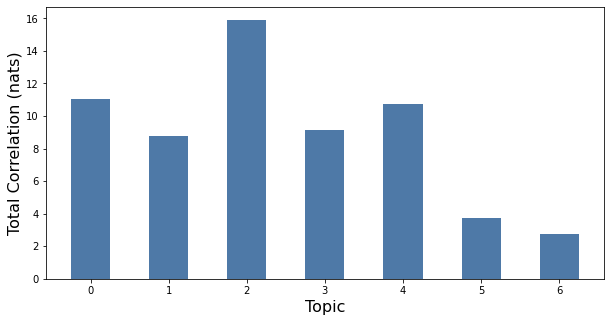

In [372]:
plt.figure(figsize=(10,5))
plt.bar(range(topic_model.tcs.shape[0]), topic_model.tcs, color='#4e79a7', width=0.5)
plt.xlabel('Topic', fontsize=16)
plt.ylabel('Total Correlation (nats)', fontsize=16);

In [356]:
topic_columns = ['topic'+str(i) for i in range(topic_model.labels.shape[1])]
ct_df = pd.DataFrame(topic_model.labels, columns=topic_columns)
dwight_df.reset_index(inplace=True, drop=True)
topic_columns = ['topic'+str(i) for i in range(topic_model.labels.shape[1])]
ct_df = pd.DataFrame(topic_model.labels, columns=topic_columns)
ct_pred_full = pd.merge(dwight_df.iloc[:, [1,2,3,4]],
                        ct_df, right_index=True, left_index=True)
ct_pred_full = ct_pred_full.sort_values('episode_no')
ct_pred_full = ct_pred_full.sort_values('episode_no')

In [361]:
ct_pred_full.columns.to_list()[4:]

['topic0', 'topic1', 'topic2', 'topic3', 'topic4']

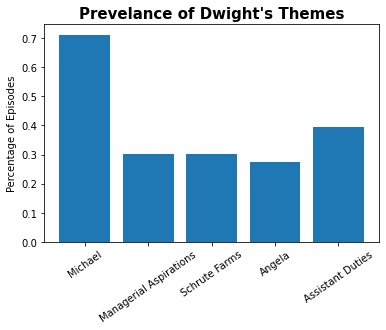

In [364]:
totals=[]
for i in ct_pred_full.columns.to_list()[4:]:
    totals.append(ct_pred_full[i].sum()/ct_pred_full.shape[0])
plt.bar([1,2,3,4,5], totals) 
plt.xticks([1,2,3,4,5], 
           labels=['Michael', 'Managerial Aspirations', 'Schrute Farms', 'Angela', 'Assistant Duties'],
          rotation=35)
plt.title("Prevelance of Dwight's Themes", weight='bold', fontsize=15)
plt.ylabel('Percentage of Episodes')
plt.show()

In [366]:
by_season=ct_pred_full.groupby('season', as_index=False)[['topic0', 'topic1', 'topic2', 'topic3', 'topic4']].mean()
by_season

,season,topic0,topic1,topic2,topic3,topic4
0,2,0.727273,0.272727,0.000000,0.363636,0.727273
1,3,0.818182,0.454545,0.363636,0.272727,0.363636
2,4,0.857143,0.285714,0.285714,0.571429,0.000000
3,5,0.615385,0.153846,0.461538,0.153846,0.461538
4,6,0.833333,0.416667,0.333333,0.166667,0.166667
5,7,0.500000,0.250000,0.333333,0.250000,0.500000


In [296]:
ct_pred_full.sort_values('topic6', ascending=False)

,episode_no,ep_name,topic0,topic1,topic2,topic3,topic4,topic5,topic6
6,"(2, 1)",The Dundies,0.999999,0.000001,0.000001,0.000001,0.000001,0.000001,0.999999
13,"(3, 8)",The Merger,0.999999,0.000001,0.000001,0.999999,0.999999,0.000001,0.999999
44,"(6, 9)",Double Date,0.999999,0.000133,0.999999,0.999999,0.999999,0.000001,0.999999
35,"(5, 27)",Cafe Disco,0.999999,0.999999,0.000001,0.000001,0.999999,0.000001,0.999999
29,"(5, 24)",Heavy Competition,0.999999,0.999999,0.999999,0.000001,0.999999,0.999999,0.999999
46,"(6, 10)",m*rder,0.999999,0.000001,0.000001,0.000001,0.000001,0.999999,0.999999
39,"(5, 11)",Moroccan Christmas,0.000001,0.998517,0.999999,0.999999,0.000001,0.000001,0.999999
48,"(6, 19)",St. Patrick's Day,0.000001,0.000001,0.999999,0.000001,0.000001,0.000001,0.999999
31,"(5, 9)",Frame Toby,0.999999,0.000001,0.999999,0.000001,0.000001,0.000001,0.999999
36,"(5, 6)",Employee Transfer,0.000001,0.000001,0.000001,0.000001,0.000001,0.999999,0.999999


In [180]:
ct_pred_full['season']=ct_pred_full['episode_no'].apply(lambda x: x[0])
by 

,season,topic0,topic1,topic2,topic3,topic4
0,2,0.097759,0.184779,0.216319,0.005479,0.017095
1,3,0.210304,0.089364,0.098294,0.060703,0.093441
2,4,0.164473,0.172459,0.090761,0.286740,0.022045
3,5,0.158853,0.077829,0.127345,0.056106,0.048463
4,6,0.007741,0.085991,0.239799,0.004040,0.091491
5,7,0.234758,0.086518,0.291550,0.004357,0.141676


In [ ]:
ct_pred_full['season']=ct_pred_full['episode_no'].apply(lambda x: x[0])
all_time = ct_pred_full.groupby('season', as_index=False)[[
    "topic0", "topic1", "topic2", "topic3", "topic4"]].mean()
by_season

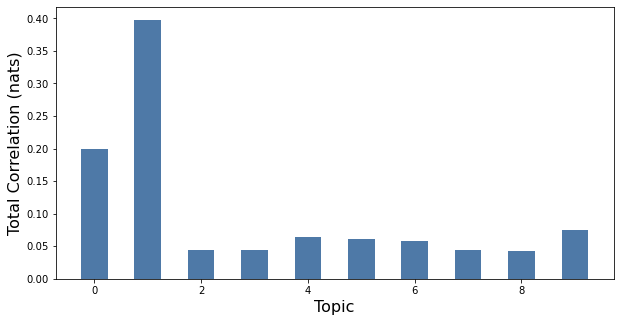

In [221]:
plt.figure(figsize=(10,5))
plt.bar(range(topic_model.tcs.shape[0]), topic_model.tcs, color='#4e79a7', width=0.5)
plt.xlabel('Topic', fontsize=16)
plt.ylabel('Total Correlation (nats)', fontsize=16);

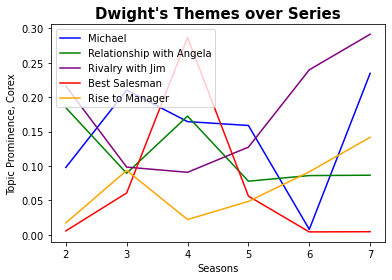

In [181]:
plt.plot(by_season['season'], by_season['topic0'], color='b')
plt.plot(by_season['season'], by_season['topic1'], color='g')
plt.plot(by_season['season'], by_season['topic2'], color='purple')
plt.plot(by_season['season'], by_season['topic3'], color='r')
plt.plot(by_season['season'], by_season['topic4'], color='orange')

plt.title("Dwight's Themes over Series", fontsize=15, weight='bold')
plt.legend(['Michael', 'Relationship with Angela', 'Rivalry with Jim','Best Salesman',
            'Rise to Manager'], loc=2)
plt.xlabel('Seasons')
plt.ylabel('Topic Prominence, Corex')
plt.savefig('dwight_themes.png', transparent=True)
plt.show()


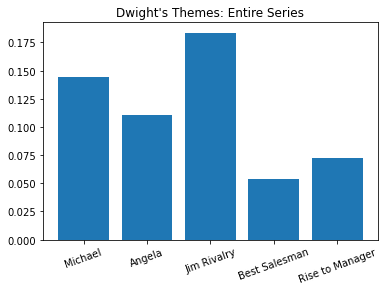

In [185]:
topic_columns = [1, 2, 3, 4, 5]
all_time = []
for i in range(2,7):
    all_time.append(np.mean(ct_pred_full.iloc[:, i]))


plt.bar(topic_columns, all_time)
plt.xticks( [1, 2, 3,4,5], 
           labels= ['Michael', 'Angela', 'Jim Rivalry', 'Best Salesman', 'Rise to Manager'],
           rotation=20)
plt.title("Dwight's Themes: Entire Series")
plt.show()

In [ ]:
print(nmf2_df.shape, mike_df.iloc[:, [1,2]].shape)

In [308]:
from sklearn.decomposition import NMF
nmf = NMF(5)
nmf.fit(doc_term_df)

/Users/aathirachennat/opt/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "
/Users/aathirachennat/opt/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1090: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


NMF(n_components=5)

In [309]:
get_topics(5, 10, nmf, terms)

54 [0.06224385 1.10875262 1.04497299 0.90283327 0.89272001 0.78382604
 0.72765887 0.672442   0.6576821  0.65057152] ['phylli', 'wed', 'ladi', 'scott', 'parti', 'dunder', 'hi', 'oscar', 'stori', 'cake']
162 [0.06224385 0.         0.         0.24338308 0.04196709 0.
 0.         0.13768923 0.         0.54530674] ['parti', 'pizza', 'york', 'scranton', 'kid', 'citi', 'sale', 'ryan', 'fire', 'goodby']
256 [0.06224385 0.         0.         0.         0.         0.11647482
 0.52316769 0.08658237 0.06960228 0.00288788] ['car', 'meredith', 'hospit', 'bodi', 'water', 'caus', 'shes', 'check', 'head', 'news']
371 [0.06224385 0.18040527 0.47443094 0.50738744 0.08400511 0.45293249
 0.         0.         0.         0.        ] ['packer', 'dollar', 'joke', 'famili', 'desk', 'line', 'manag', 'truck', 'sale', 'todd']
172 [0.06224385 0.         0.         0.         0.         0.15067726
 0.07633421 0.08813232 0.         0.06960228] ['stanley', 'team', 'manag', 'winner', 'dog', 'word', 'anybodi', 'andi', 

In [212]:
get_topics(3, 10, nmf, terms)

11 [0.01333123 1.5431537  1.25866342 0.82622667 0.59232168 0.43329149
 0.3945215  0.36118114 0.25262583 0.2031977 ] ['compani', 'paper', 'busi', 'job', 'son', 'michael', 'life', 'mifflin', 'pam', 'jan']
30 [0.01333123 0.36118114 0.11735823 0.         0.         0.
 0.         0.13374694 0.25262583 0.1661639 ] ['dunder', 'mifflin', 'offic', 'phylli', 'heart', 'manag', 'work', 'idea', 'pam', 'world']
23 [0.01333123 0.13700033 0.         0.25262583 0.11609761 0.
 0.01333123 0.82622667 0.03297858 0.        ] ['everybodi', 'dwight', 'manag', 'pam', 'feel', 'jim', 'bit', 'job', 'friend', 'phylli']


In [304]:
get_topics(3, 10, lsa3, terms)

217 [0.01055749 0.18984799 0.17547695 0.17346196 0.16813816 0.16659812
 0.15006373 0.13985072 0.13068225 0.1213249 ] ['parti', 'car', 'stanley', 'phylli', 'pizza', 'york', 'scranton', 'manag', 'head', 'kid']
328 [0.01055749 0.16813816 0.16659812 0.07100565 0.1213249  0.06987649
 0.15006373 0.08363077 0.10685015 0.11886506] ['parti', 'pizza', 'york', 'citi', 'kid', 'fire', 'scranton', 'goodby', 'sale', 'ryan']
26 [0.01055749 0.10942616 0.05904496 0.06552897 0.07980503 0.07711015
 0.13068225 0.08412203 0.06949421 0.03419901] ['car', 'meredith', 'hospit', 'water', 'bodi', 'dog', 'head', 'caus', 'check', 'bat']


In [63]:
corpus = matutils.Sparse2Corpus(X.transpose())
id2word = dict((v,k) for k,v in cv.vocabulary_.items())
lda2 = models.LdaModel(corpus=corpus, num_topics=5, id2word=id2word, passes=100)


In [64]:
lda2.print_topics()

[(0,
  '0.056*"ryan" + 0.042*"paper" + 0.042*"business" + 0.040*"company" + 0.024*"scott" + 0.019*"kid" + 0.018*"send" + 0.016*"car" + 0.015*"man" + 0.015*"bad"'),
 (1,
  '0.031*"woman" + 0.031*"holly" + 0.026*"date" + 0.024*"kevin" + 0.021*"stanley" + 0.020*"happy" + 0.019*"old" + 0.019*"wait" + 0.018*"meet" + 0.018*"see"'),
 (2,
  '0.019*"toby" + 0.015*"leave" + 0.015*"friend" + 0.014*"phyllis" + 0.014*"man" + 0.014*"kevin" + 0.013*"phone" + 0.013*"mifflin" + 0.013*"scranton" + 0.012*"dunder"'),
 (3,
  '0.030*"party" + 0.025*"meredith" + 0.022*"car" + 0.020*"life" + 0.019*"oscar" + 0.018*"god" + 0.018*"point" + 0.017*"jan" + 0.017*"stanley" + 0.016*"well"'),
 (4,
  '0.035*"fire" + 0.027*"stanley" + 0.024*"phyllis" + 0.018*"leave" + 0.018*"head" + 0.017*"big" + 0.016*"fun" + 0.015*"hate" + 0.015*"god" + 0.014*"sit"')]

In [60]:
corpus = matutils.Sparse2Corpus(X.transpose())
id2word = dict((v,k) for k,v in tfidf.vocabulary_.items())
lda = models.LdaModel(corpus=corpus, num_topics=5, id2word=id2word, passes=100)

In [61]:
lda.print_topics()

[(0,
  '0.002*"base" + 0.002*"center" + 0.002*"fault" + 0.002*"fix" + 0.002*"certain" + 0.002*"screen" + 0.002*"imagine" + 0.002*"difference" + 0.002*"normal" + 0.002*"one"'),
 (1,
  '0.002*"base" + 0.002*"center" + 0.002*"fault" + 0.002*"fix" + 0.002*"certain" + 0.002*"screen" + 0.002*"imagine" + 0.002*"difference" + 0.002*"normal" + 0.002*"one"'),
 (2,
  '0.002*"base" + 0.002*"center" + 0.002*"fault" + 0.002*"fix" + 0.002*"certain" + 0.002*"screen" + 0.002*"imagine" + 0.002*"difference" + 0.002*"normal" + 0.002*"course"'),
 (3,
  '0.002*"base" + 0.002*"center" + 0.002*"fault" + 0.002*"fix" + 0.002*"certain" + 0.002*"imagine" + 0.002*"screen" + 0.002*"difference" + 0.002*"normal" + 0.002*"one"'),
 (4,
  '0.007*"stanley" + 0.006*"toby" + 0.006*"paper" + 0.006*"phyllis" + 0.006*"party" + 0.005*"kevin" + 0.005*"holly" + 0.005*"jan" + 0.005*"business" + 0.005*"company"')]

In [237]:
ct_pred_full['character']='dwight'
ct_pred_full.to_csv('to_tableau/dwight_topics.csv')
cv_counts = CountVectorizer(lowercase=False, stop_words = stopwords, max_features=50) 
X_counts=cv_counts.fit_transform(dwight_df.clean_doc)
doc_term_df_counts = pd.DataFrame(X_counts.toarray(), columns=cv_counts.get_feature_names())
terms_counts = np.array(doc_term_df.columns.to_list())

In [238]:
dwight_df.to_csv('to_tableau/dwight_lines.csv')

In [250]:
rows=[]
words = doc_term_df_counts.columns.tolist()
counts = []
for i in words:
    counts.append(doc_term_df_counts[i].sum())

top_words = list(zip(words, counts))
for i in top_words:
    row_dict = {'word': i[0], 'count': i[1]}
    rows.append(row_dict)
dwight_counts = pd.DataFrame(rows)
dwight_counts.sort_values('count', ascending=False, inplace=True)  
dwight_counts.to_csv('to_tableau/dwight_counts.csv')